# Code for competition

In [1]:
#!apt -y install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

#!pip uninstall -y tensorflow
#!pip uninstall -y tensorflow-transform
#!pip uninstall -y tensorflow-io
#!pip install tensorflow-transform
#!pip install tensorflow
#!rm -r /kaggle/working/validation /kaggle/working/training /kaggle/working/training_aug /kaggle/working/training_data_final

In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
import re
import time
from IPython.display import FileLink

#!nvidia-smi

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable distributed training
#strategy = tf.distribute.MirroredStrategy()

#found on stack overlfow
tf.config.run_functions_eagerly(True)

# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)


2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-19 18:08:32.291955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:08:32.407069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:08:32.407869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:08:32.409735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Metadata

In [3]:
classes = ["Species1", "Species2", "Species3", "Species4",
           "Species5", "Species6", "Species7", "Species8"]
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
#inflation_coeff = 1.5


Nvidia SLI GPU optimizations for 2xT4 on kaggle

In [4]:
# Disable AutoShard
#options = tf.data.Options()
#options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF


In [5]:
path = os.getcwd()
if not os.path.exists(path+'/training_data_final'):
    shutil.copytree('../input/competition/training_data_final',
                    os.getcwd() + r'/training_data_final')
print(os.listdir(os.getcwd()))


['__notebook_source__.ipynb', 'xception_tuned_v2.zip', 'xception_supernet.zip', 'xception_tuned_v2', 'xception_tuned_v1.zip', 'xception_supernet', 'validation', 'training_aug', 'xception_tuned_v1', 'training_data_final', 'training', '.virtual_documents']


### Prepare the environment

In [6]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)

        # Create path of the class
        class_source = source + '/' + folder
        # List of files for the class
        files = os.listdir(class_source)
        # Split is performed randomly
        random.shuffle(files)

        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            # Copy an image in the training set
            dest = shutil.copy(
                class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])

        # Create validation set randomly
        for j in range(i + 1, len(files)):
            # copy an image in the validation set
            dest = shutil.copy(
                class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])


### Prepare the training set for standardization

In [7]:
from tensorflow.keras.applications.xception import preprocess_input


def preprocessing(image):
    # return tf.image.adjust_saturation(image, 3)
    return preprocess_input(image)
    # return image


In [8]:
samples = []
targets = []

dest_train = os.getcwd() + '/training'

for folder in os.listdir(dest_train):
    dest_class = dest_train + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = preprocessing(np.squeeze(np.expand_dims(temp, axis=0)))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
X_train = np.array(samples)
y_train = np.array(targets, dtype=np.uint8)
print(X_train.shape, X_train.dtype, sep=", ")
print(y_train.shape, y_train.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_train:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_train], np.int32))

class_weights = dict(enumerate(class_weight.compute_class_weight(
    'balanced', classes=labels, y=y_numeric)))
print(class_weights)


(2829, 96, 96, 3), float32
(2829, 8), uint8
{0: 2.389358108108108, 1: 0.8320588235294117, 2: 0.8583131067961165, 3: 0.8667279411764706, 4: 0.8340212264150944, 5: 1.9978813559322033, 6: 0.8243006993006993, 7: 0.8709975369458128}


### Static augmentation (only on training set)

In [9]:
static_aug = True
balanced = False

if static_aug and not os.path.exists(path+'/training_aug'):
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train)

    desired_amount = int(537 * train_split)

    static_gen = ImageDataGenerator()

    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder
        label = int(re.sub("\D", "", folder)) - 1

        if balanced:
            to_produce = desired_amount - len(os.listdir(dest_path))
        else:
            class_expansion = [6, 1, 1, 1, 1, 3, 1, 4]
            to_produce = (
                class_expansion[label] * desired_amount) - len(os.listdir(dest_path))

        static_gen_data = static_gen.flow_from_directory(dest_train,
                                                         batch_size=1,
                                                         target_size=input_size,
                                                         classes=[folder],
                                                         class_mode='categorical',      # Targets are directly converted into one-hot vectors
                                                         shuffle=False,
                                                         seed=seed)

        print(f'Computing {to_produce} augmented images for target "{folder}"')
        os.chdir(dest_path)
        for i in range(0, to_produce):
            Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(
                np.uint8)).save(f'aug{i:05}.jpg')
        os.chdir('../')

    os.chdir('../')
    print('\n' + os.getcwd())


### Online augmentation
Lets create the generators we'll need...

In [10]:
#batch_size = 128 * strategy.num_replicas_in_sync
batch_size = 128
epochs = 400

print("batch size = ", batch_size)


batch size =  128


Input pre-processing for the supernet input

Generators

In [11]:

train_data_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=30,
                                    height_shift_range=30,
                                    horizontal_flip=True,
                                    brightness_range=[0.8, 1.2],
                                    # channel_shift_range=150,
                                    zoom_range=[0.7, 1.3],
                                    shear_range=0.1,
                                    fill_mode='reflect',
                                    preprocessing_function=preprocessing
                                    )

valid_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)

# Fit the standardization values
# train_data_gen.fit(X_train)
# valid_data_gen.fit(X_train)


... using flow_from_directory

In [12]:
# Setting right paths
path = os.getcwd()
if static_aug:
    training_dir = path + '/training_aug'
else:
    training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(
                                                   tf.float16, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

#train_dataset = train_dataset.with_options(options)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(
                                                   tf.float16, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

#valid_dataset = valid_dataset.with_options(options)
valid_dataset = valid_dataset.repeat()


Found 7722 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


2022-11-19 18:08:34.837229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 18:08:34.837734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:08:34.839034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:08:34.840242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### Prepare the validation set for evaluation purposes

In [13]:
samples = []
targets = []

#mean = train_data_gen.mean
#std = train_data_gen.std

dest_valid = os.getcwd() + '/validation'

for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        #image = preprocessing((np.squeeze(np.expand_dims(temp, axis=0)) - mean) / std)
        image = preprocessing(np.squeeze(np.expand_dims(temp, axis=0)))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)

X_val = np.array(samples, dtype=np.float16)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")


(713, 96, 96, 3), float16
(713, 8), uint8


### Models definition functions and utilities for model evaluation

In [14]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        # I use ._decayed_lr method instead of .lr
        return optimizer._decayed_lr(tf.float32)
    return lr

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)


'''
start = time.time()
class ElapsedTimeCallback(tfk.callbacks.Callback):
    def on_test_end(self, epoch, logs=None):
        el = time.time() - start
        print(f'\nElapsed time: {int(el // 60)} minutes {(el % 60):.3f} seconds')
'''


"\nstart = time.time()\nclass ElapsedTimeCallback(tfk.callbacks.Callback):\n    def on_test_end(self, epoch, logs=None):\n        el = time.time() - start\n        print(f'\nElapsed time: {int(el // 60)} minutes {(el % 60):.3f} seconds')\n"

In [15]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.plot(history['loss'], label='Std training',
             alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Std validation',
             alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15, 5))
    plt.plot(history['accuracy'], label='Std training',
             alpha=.8, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Std validation',
             alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper right')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()


In [16]:
def score_model(model):
    predictions = model.predict(X_val)
    cm = confusion_matrix(np.argmax(y_val, axis=-1),
                          np.argmax(predictions, axis=-1))

    accuracy = accuracy_score(
        np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(
        np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_val, axis=-1),
                          np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_val, axis=-1),
                  np.argmax(predictions, axis=-1), average=None)
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()


### Supernet model definitions

In [17]:
def build_supernet_model_l2_resize(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=(192, 192, 3))
    supernet.trainable = True 
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)

    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer='l2',
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'xception_v2_l2_resize')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics='accuracy')

    # Return the model
    return model

In [18]:
def build_supernet_model_l2(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    supernet.trainable = True 
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer='l2',
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'xception_v2_l2')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics='accuracy')

    # Return the model
    return model

## Fine tuning

In [19]:
def tune_supernetL2resize_v1(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=(192, 192, 3))
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2_resize').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    #for i, layer in enumerate(supernet.layers):
    #    print(i, layer.name, layer.trainable)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic",
                      name='resizing')(input_layer)

    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x_gap = x

    #x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    x = tfkl.Dense(
        units=2048,
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        kernel_regularizer='l2',
        name='classifier')(x)

    # Skip connection
    x = tfkl.Add(name='adder')([x_gap, x])

    #x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units=len(classes),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_resize_v1')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model


In [20]:
def tune_supernetL2resize_v2(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=(192, 192, 3))
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2_resize').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    #for i, layer in enumerate(supernet.layers):
    #    print(i, layer.name, layer.trainable)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic",
                      name='resizing')(input_layer)

    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x_gap = x

    x = tfkl.Dense(
        units=2048,
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        kernel_regularizer='l2',
        name='classifier')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add(name='adder')([x_gap, x])

    #x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units=len(classes),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_resize_v2')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model


In [21]:
def tune_supernetL2resize_v3(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=(192, 192, 3))
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2_resize').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(x)

    x_gap = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x1 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x_gap)
    x1 = tfkl.Dropout(0.2, seed=seed, name='dropout1')(x1)

    x2 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x_gap)
    x2 = tfkl.Dropout(0.2, seed=seed, name='dropout2')(x2)
    x2 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x2)
    x2 = tfkl.Dropout(0.2, seed=seed, name='dropout3')(x2)

    x3 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x_gap)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout4')(x3)
    x3 = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x3)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout5')(x3)
    x3 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense6')(x3)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout6')(x3)

    # Skip connection
    x = tfkl.Add()([x_gap, x1, x2, x3])

    x = tfkl.Dropout(0.3, seed=seed, name='dropout7')(x)
    
    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_resize_v3')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model

In [22]:
def tune_supernetL2_v1(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=input_shape)
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    #for i, layer in enumerate(supernet.layers):
    #    print(i, layer.name, layer.trainable)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x_gap = x

    x = tfkl.Dense(
        units=2048,
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        kernel_regularizer='l2',
        name='classifier')(x)
   # x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add(name='adder')([x_gap, x])

    #x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units=len(classes),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_v1')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model


In [23]:
def tune_supernetL2_v2(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=input_shape)
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    #for i, layer in enumerate(supernet.layers):
    #    print(i, layer.name, layer.trainable)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x_gap = x

    x = tfkl.Dense(
        units=2048,
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        kernel_regularizer='l2',
        name='classifier')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add(name='adder')([x_gap, x])

    #x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units=len(classes),
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_v2')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model


In [24]:
def tune_supernetL2_v3(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(
        include_top=False, input_shape=input_shape)
    supernet.set_weights(tfk.models.load_model('xception_supernet_l2').get_layer('xception').get_weights())
    # Use the supernet only as feature extractor
    supernet.trainable = True  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-16]):
        layer.trainable = False
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #x = tfkl.Resizing(192, 192, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(input_layer)

    x_gap = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x1 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x_gap)
    x1 = tfkl.Dropout(0.2, seed=seed, name='dropout1')(x1)

    x2 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x_gap)
    x2 = tfkl.Dropout(0.2, seed=seed, name='dropout2')(x2)
    x2 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x2)
    x2 = tfkl.Dropout(0.2, seed=seed, name='dropout3')(x2)

    x3 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x_gap)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout4')(x3)
    x3 = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x3)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout5')(x3)
    x3 = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense6')(x3)
    x3 = tfkl.Dropout(0.2, seed=seed, name='dropout6')(x3)

    # Skip connection
    x = tfkl.Add()([x_gap, x1, x2, x3])

    x = tfkl.Dropout(0.3, seed=seed, name='dropout7')(x)
    
    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer,
                      outputs=output_layer, name='tuned_model_l2_v3')

    # Compile the model
    optimizer=tfk.optimizers.Adam()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model

## Models training and evaluation

## Supernet Training

In [25]:
initial_lr = 5e-4 # suggested 5e-5 for transfer learning applications
def scheduler_supernet(epoch, lr):
    if epoch <= 10:
        return initial_lr
    else:
        return max(initial_lr * tf.math.exp(- (epoch-10) / 10.0), 5e-5)
    

83697664/83683744 [==============================] - 3s 0us/step
Model: "xception_v2_l2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 8)                 16392     
Total params: 20,877,872
Trainable params: 20,823,344
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/400


2022-11-19 18:08:42.354614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-19 18:08:43.597298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


22/22 [==============================] - 26s 719ms/step - loss: 2.2114 - accuracy: 0.4094 - val_loss: 2.5064 - val_accuracy: 0.0659
Epoch 2/400
22/22 [==============================] - 15s 696ms/step - loss: 1.4322 - accuracy: 0.5856 - val_loss: 2.0961 - val_accuracy: 0.3338
Epoch 3/400
22/22 [==============================] - 16s 730ms/step - loss: 1.1403 - accuracy: 0.6568 - val_loss: 2.5967 - val_accuracy: 0.3829
Epoch 4/400
22/22 [==============================] - 15s 706ms/step - loss: 0.9464 - accuracy: 0.7354 - val_loss: 2.4045 - val_accuracy: 0.3394
Epoch 5/400
22/22 [==============================] - 15s 674ms/step - loss: 0.7755 - accuracy: 0.7880 - val_loss: 2.4049 - val_accuracy: 0.3801
Epoch 6/400
22/22 [==============================] - 15s 685ms/step - loss: 0.7174 - accuracy: 0.7956 - val_loss: 1.4526 - val_accuracy: 0.5849
Epoch 7/400
22/22 [==============================] - 15s 699ms/step - loss: 0.6875 - accuracy: 0.8143 - val_loss: 1.1159 - val_accuracy: 0.6634
Epoc

2022-11-19 18:21:18.363940: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


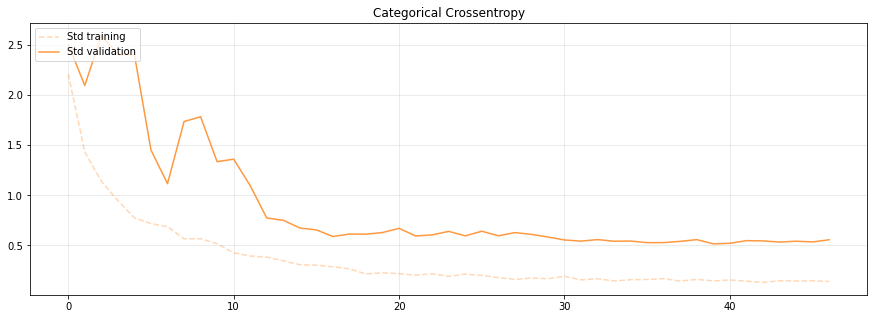

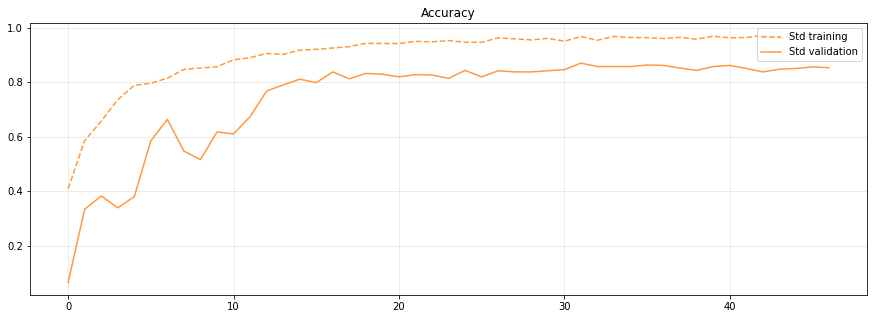

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8696
Precision: 0.8578
Recall: 0.8393
F1: [0.6111 0.8756 0.9109 0.8597 0.9132 0.8537 0.9346 0.8141]


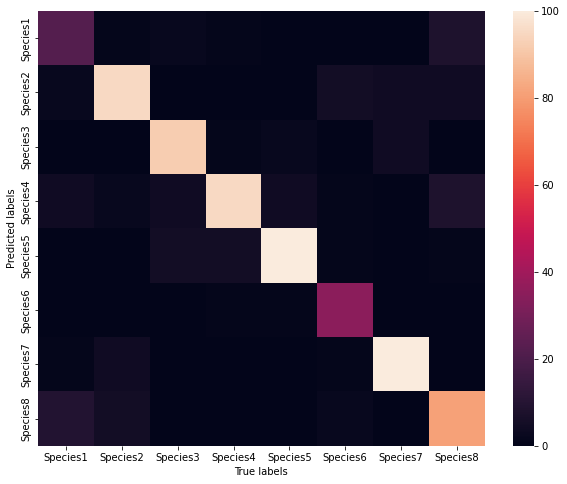

In [26]:
supernet_model = build_supernet_model_l2(input_shape)
supernet_model.summary()

# Train the network
history = supernet_model.fit(x=train_dataset,
                    epochs=epochs,                                    
                    steps_per_epoch=int(len(X_train)/batch_size),   # 1 epoch will be considered as 1 pass over the training augmented dataset. Thanks to inflation of training set we perform oversampling
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,                       #Class weights not used in the loss function during supernet tuning
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
                                 tfk.callbacks.LearningRateScheduler(scheduler_supernet)]
).history

supernet_model.save('xception_supernet_l2', include_optimizer=False)

shutil.make_archive('xception_supernet_l2', 'zip', 'xception_supernet_l2')
FileLink(r'xception_supernet_l2.zip')

plot_history(history)
score_model(supernet_model)

Model: "xception_v2_l2_resize"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 8)                 16392     
Total params: 20,877,872
Trainable params: 20,823,344
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/400


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


22/22 [==============================] - 39s 2s/step - loss: 1.8418 - accuracy: 0.4978 - val_loss: 3.7121 - val_accuracy: 0.1950
Epoch 2/400
22/22 [==============================] - 26s 1s/step - loss: 1.0417 - accuracy: 0.7060 - val_loss: 2.7321 - val_accuracy: 0.3955
Epoch 3/400
22/22 [==============================] - 26s 1s/step - loss: 0.7669 - accuracy: 0.7886 - val_loss: 1.7424 - val_accuracy: 0.4979
Epoch 4/400
22/22 [==============================] - 26s 1s/step - loss: 0.6414 - accuracy: 0.8349 - val_loss: 1.6396 - val_accuracy: 0.5554
Epoch 5/400
22/22 [==============================] - 26s 1s/step - loss: 0.5979 - accuracy: 0.8438 - val_loss: 1.1149 - val_accuracy: 0.6676
Epoch 6/400
22/22 [==============================] - 25s 1s/step - loss: 0.4786 - accuracy: 0.8875 - val_loss: 1.0991 - val_accuracy: 0.6704
Epoch 7/400
22/22 [==============================] - 25s 1s/step - loss: 0.4413 - accuracy: 0.8920 - val_loss: 1.2317 - val_accuracy: 0.6522
Epoch 8/400
22/22 [======

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


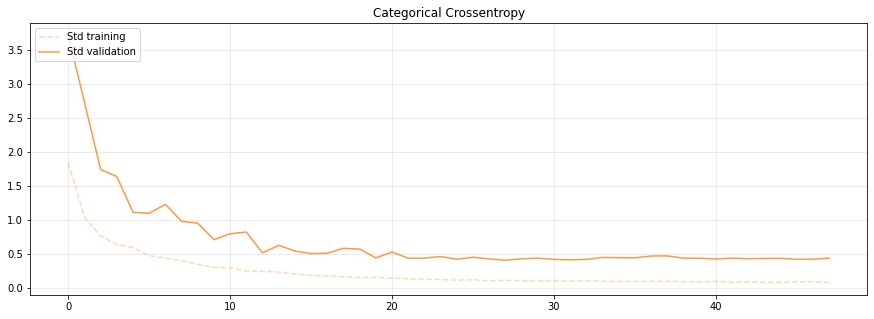

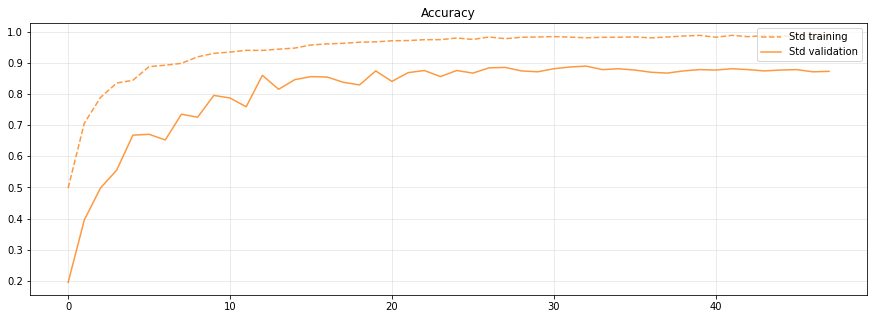

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8892
Precision: 0.8918
Recall: 0.8531
F1: [0.6333 0.88   0.9194 0.8962 0.9116 0.881  0.9488 0.8529]


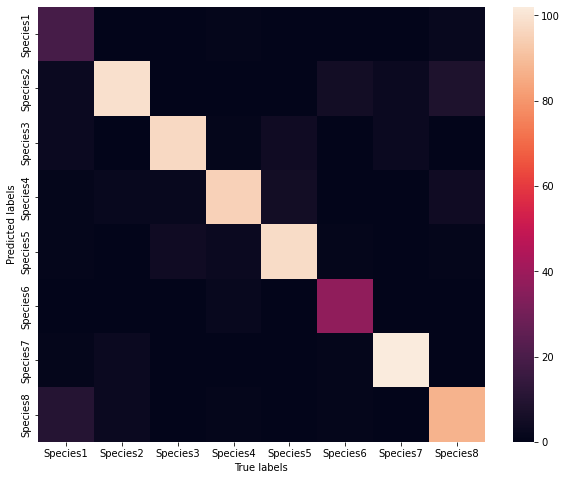

In [27]:
  
supernet_model = build_supernet_model_l2_resize(input_shape)
supernet_model.summary()

# Train the network
history = supernet_model.fit(x=train_dataset,
                    epochs=epochs,                                    
                    steps_per_epoch=int(len(X_train)/batch_size),   # 1 epoch will be considered as 1 pass over the training augmented dataset. Thanks to inflation of training set we perform oversampling
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,                       #Class weights not used in the loss function during supernet tuning
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
                                 tfk.callbacks.LearningRateScheduler(scheduler_supernet)]
).history

supernet_model.save('xception_supernet_l2_resize', include_optimizer=False)

shutil.make_archive('xception_supernet_l2_resize', 'zip', 'xception_supernet_l2_resize')
FileLink(r'xception_supernet_l2_resize.zip')

plot_history(history)
score_model(supernet_model)

## Fine tuning of L2 regularization with input resizing

In [28]:
# learning rate scheduler for fine tuning
initial_lr = 1e-4
def scheduler_tuning(epoch, lr):
    if epoch <= 5:
        return initial_lr
    else:
        return max(initial_lr * tf.math.exp(- (epoch-5) / 30.0), 5e-6)

Model: "tuned_model_l2_resize_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 192, 192, 3)  0           input_layer[0][0]                
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    resizing[0][0]                   
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
___________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 63s 1s/step - loss: 34.9148 - accuracy: 0.9873 - val_loss: 29.5776 - val_accuracy: 0.8934
Epoch 2/400
61/61 [==============================] - 64s 1s/step - loss: 24.6631 - accuracy: 0.9828 - val_loss: 20.9178 - val_accuracy: 0.8710
Epoch 3/400
61/61 [==============================] - 62s 1s/step - loss: 17.2249 - accuracy: 0.9856 - val_loss: 14.6673 - val_accuracy: 0.8724
Epoch 4/400
61/61 [==============================] - 62s 1s/step - loss: 11.8836 - accuracy: 0.9841 - val_loss: 10.2058 - val_accuracy: 0.8808
Epoch 5/400
61/61 [==============================] - 63s 1s/step - loss: 8.0844 - accuracy: 0.9852 - val_loss: 7.0394 - val_accuracy: 0.8822
Epoch 6/400
61/61 [==============================] - 62s 1s/step - loss: 5.4099 - accuracy: 0.9885 - val_loss: 4.7743 - val_accuracy: 0.8752
Epoch 7/400
61/61 [==============================] - 62s 1s/step - loss: 3.5848 - accuracy: 0.9891 - val_loss: 3.3479 - val_accuracy: 0.8668
Epoch 8/400
61/61

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


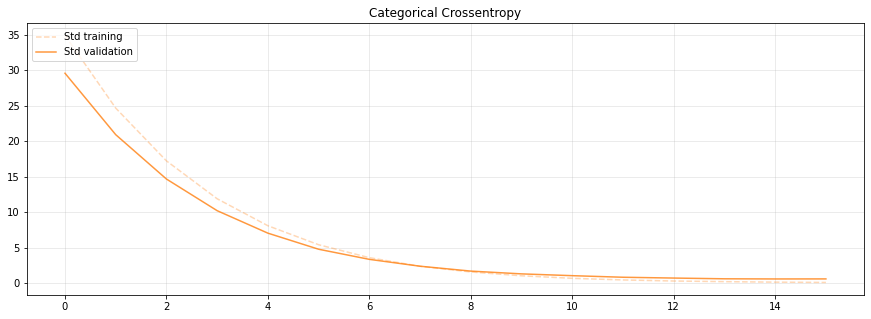

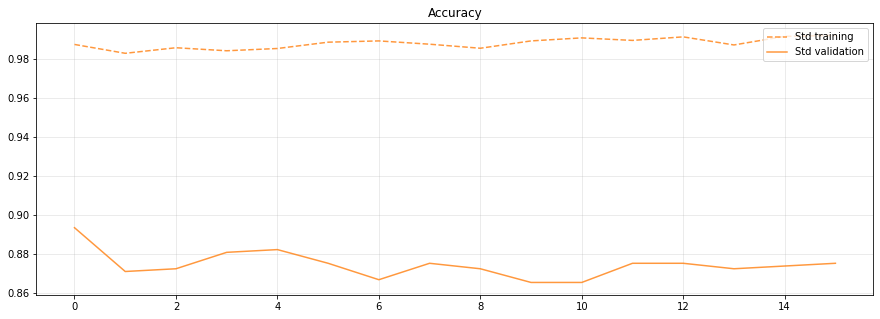

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8934
Precision: 0.8988
Recall: 0.8547
F1: [0.6207 0.9    0.9143 0.8972 0.9057 0.881  0.9585 0.8626]


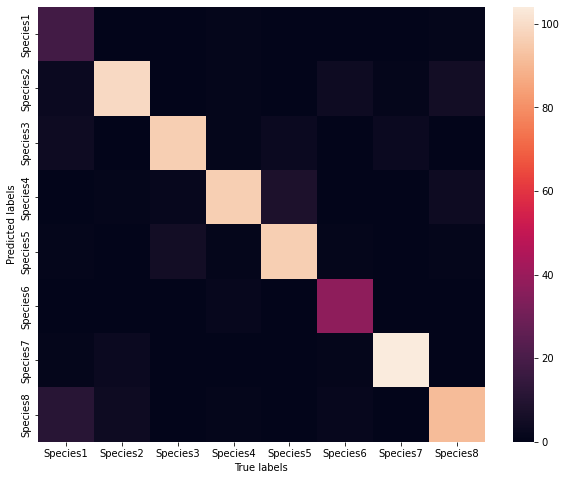

In [29]:
tuning_model_l2_resize_v1 = tune_supernetL2resize_v1(input_shape)
tuning_model_l2_resize_v1.summary()

history = tuning_model_l2_resize_v1.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_resize_v1.save('xception_tuned_l2_resize_v1', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_resize_v1', 'zip', 'xception_tuned_l2_resize_v1')
FileLink(r'xception_tuned_l2_resize_v1.zip')

plot_history(history)
score_model(tuning_model_l2_resize_v1)

Model: "tuned_model_l2_resize_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 192, 192, 3)  0           input_layer[0][0]                
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    resizing[0][0]                   
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
___________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 60s 982ms/step - loss: 34.9333 - accuracy: 0.9838 - val_loss: 29.6750 - val_accuracy: 0.8640
Epoch 2/400
61/61 [==============================] - 63s 1s/step - loss: 24.7045 - accuracy: 0.9859 - val_loss: 20.9246 - val_accuracy: 0.8864
Epoch 3/400
61/61 [==============================] - 62s 1s/step - loss: 17.2864 - accuracy: 0.9839 - val_loss: 14.7347 - val_accuracy: 0.8738
Epoch 4/400
61/61 [==============================] - 62s 1s/step - loss: 11.9480 - accuracy: 0.9865 - val_loss: 10.2288 - val_accuracy: 0.8668
Epoch 5/400
61/61 [==============================] - 63s 1s/step - loss: 8.1418 - accuracy: 0.9854 - val_loss: 7.0831 - val_accuracy: 0.8738
Epoch 6/400
61/61 [==============================] - 62s 1s/step - loss: 5.4607 - accuracy: 0.9873 - val_loss: 4.8763 - val_accuracy: 0.8696
Epoch 7/400
61/61 [==============================] - 63s 1s/step - loss: 3.6299 - accuracy: 0.9870 - val_loss: 3.3733 - val_accuracy: 0.8780
Epoch 8/400
61

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


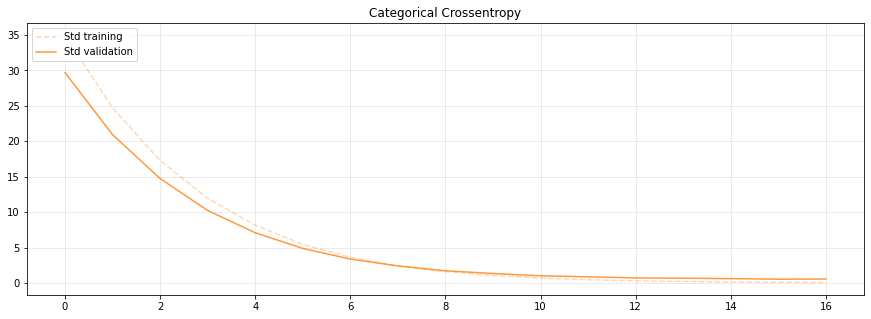

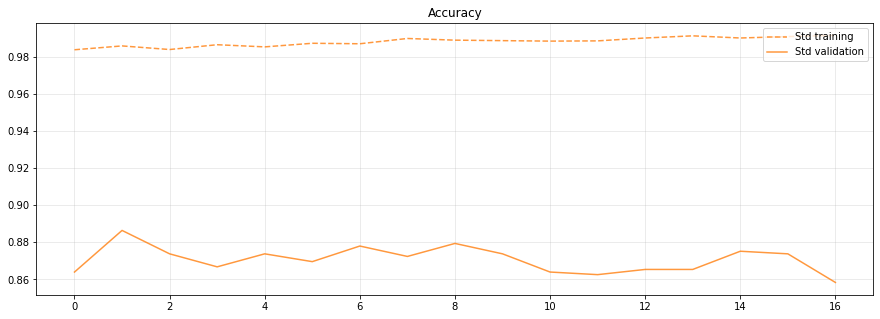

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8864
Precision: 0.8896
Recall: 0.8483
F1: [0.6102 0.8789 0.9246 0.8704 0.905  0.881  0.964  0.8515]


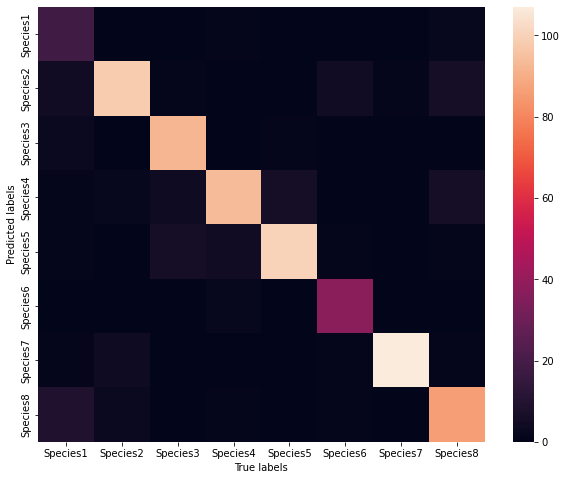

In [30]:
tuning_model_l2_resize_v2 = tune_supernetL2resize_v2(input_shape)
tuning_model_l2_resize_v2.summary()

history = tuning_model_l2_resize_v2.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_resize_v2.save('xception_tuned_l2_resize_v2', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_resize_v2', 'zip', 'xception_tuned_l2_resize_v2')
FileLink(r'xception_tuned_l2_resize_v2.zip')

plot_history(history)
score_model(tuning_model_l2_resize_v2)

Model: "tuned_model_l2_resize_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 192, 192, 3)  0           input_layer[0][0]                
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    resizing[0][0]                   
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
___________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 63s 1s/step - loss: 0.0685 - accuracy: 0.9762 - val_loss: 0.6055 - val_accuracy: 0.8808
Epoch 2/400
61/61 [==============================] - 63s 1s/step - loss: 0.0524 - accuracy: 0.9826 - val_loss: 0.6058 - val_accuracy: 0.8682
Epoch 3/400
61/61 [==============================] - 64s 1s/step - loss: 0.0562 - accuracy: 0.9819 - val_loss: 0.6776 - val_accuracy: 0.8668
Epoch 4/400
61/61 [==============================] - 63s 1s/step - loss: 0.0475 - accuracy: 0.9824 - val_loss: 0.6442 - val_accuracy: 0.8612
Epoch 5/400
61/61 [==============================] - 63s 1s/step - loss: 0.0452 - accuracy: 0.9832 - val_loss: 0.6215 - val_accuracy: 0.8513
Epoch 6/400
61/61 [==============================] - 63s 1s/step - loss: 0.0370 - accuracy: 0.9858 - val_loss: 0.5982 - val_accuracy: 0.8597
Epoch 7/400
61/61 [==============================] - 63s 1s/step - loss: 0.0443 - accuracy: 0.9846 - val_loss: 0.5697 - val_accuracy: 0.8640
Epoch 8/400
61/61 [======

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


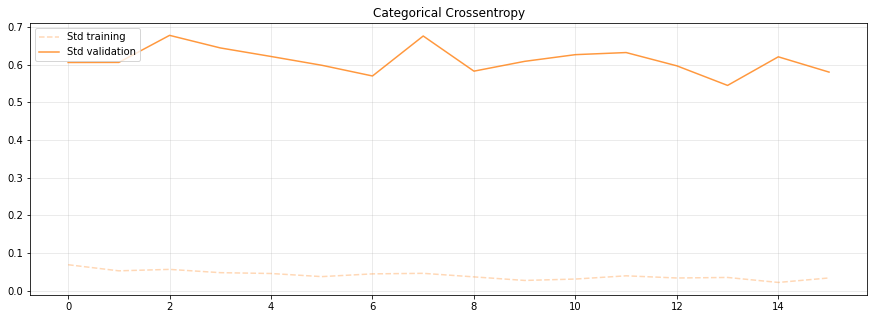

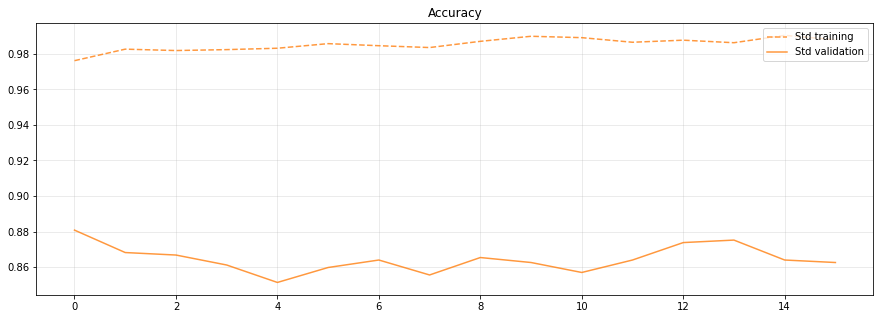

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8808
Precision: 0.8816
Recall: 0.8429
F1: [0.6129 0.8761 0.9118 0.8676 0.9005 0.8642 0.9533 0.8612]


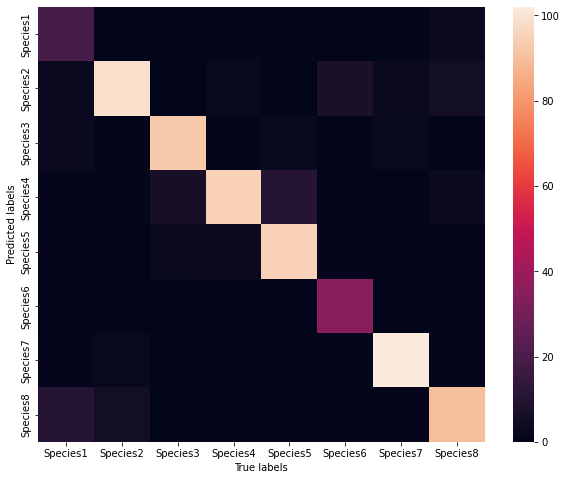

In [31]:
tuning_model_l2_resize_v3 = tune_supernetL2resize_v3(input_shape)
tuning_model_l2_resize_v3.summary()

history = tuning_model_l2_resize_v3.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_resize_v3.save('xception_tuned_l2_resize_v3', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_resize_v3', 'zip', 'xception_tuned_l2_resize_v3')
FileLink(r'xception_tuned_l2_resize_v3.zip')

plot_history(history)
score_model(tuning_model_l2_resize_v3)

## Fine tuning of L2 regularization without resizing

Model: "tuned_model_l2_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 3, 2048)   20861480    input_layer[0][0]                
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
classifier (Dense)              (None, 2048)         4196352     gap[0][0]                        
__________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 36s 590ms/step - loss: 35.1044 - accuracy: 0.9604 - val_loss: 29.9695 - val_accuracy: 0.8275
Epoch 2/400
61/61 [==============================] - 36s 602ms/step - loss: 25.0096 - accuracy: 0.9643 - val_loss: 21.3525 - val_accuracy: 0.8640
Epoch 3/400
61/61 [==============================] - 36s 589ms/step - loss: 17.6271 - accuracy: 0.9644 - val_loss: 15.0739 - val_accuracy: 0.8569
Epoch 4/400
61/61 [==============================] - 35s 584ms/step - loss: 12.2498 - accuracy: 0.9703 - val_loss: 10.6175 - val_accuracy: 0.8569
Epoch 5/400
61/61 [==============================] - 35s 582ms/step - loss: 8.4149 - accuracy: 0.9632 - val_loss: 7.4073 - val_accuracy: 0.8429
Epoch 6/400
61/61 [==============================] - 35s 582ms/step - loss: 5.6973 - accuracy: 0.9687 - val_loss: 5.1227 - val_accuracy: 0.8499
Epoch 7/400
61/61 [==============================] - 36s 592ms/step - loss: 3.8282 - accuracy: 0.9684 - val_loss: 3.6091 - val_accuracy: 0.8

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


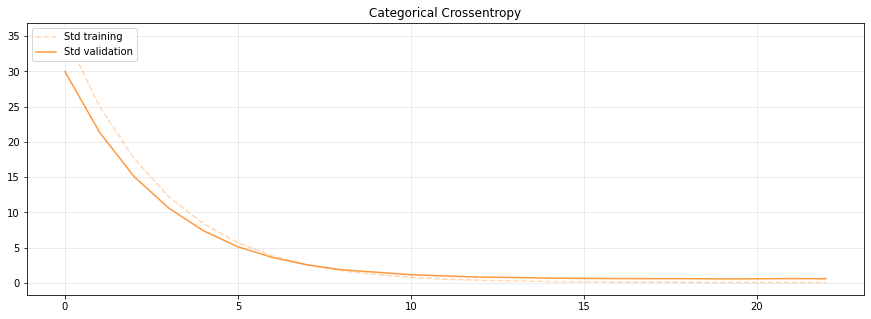

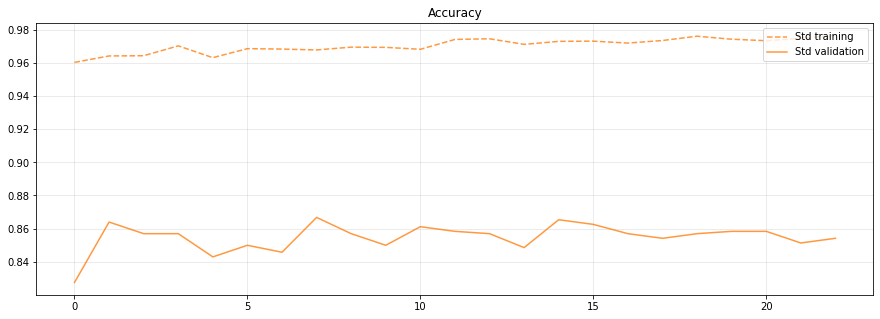

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8668
Precision: 0.8488
Recall: 0.826
F1: [0.5278 0.8634 0.9154 0.892  0.8969 0.8101 0.9333 0.8358]


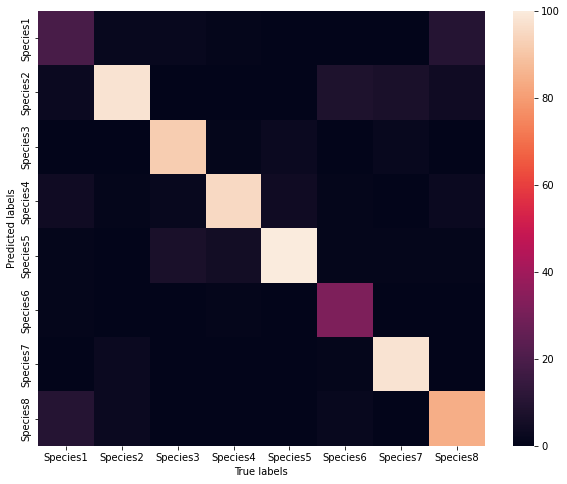

In [32]:
tuning_model_l2_v1 = tune_supernetL2_v1(input_shape)
tuning_model_l2_v1.summary()

history = tuning_model_l2_v1.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_v1.save('xception_tuned_l2_v1', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_v1', 'zip', 'xception_tuned_l2_v1')
FileLink(r'xception_tuned_l2_v1.zip')

plot_history(history)
score_model(tuning_model_l2_v1)

Model: "tuned_model_l2_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 3, 2048)   20861480    input_layer[0][0]                
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
classifier (Dense)              (None, 2048)         4196352     gap[0][0]                        
__________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 36s 591ms/step - loss: 35.1336 - accuracy: 0.9636 - val_loss: 30.0384 - val_accuracy: 0.8555
Epoch 2/400
61/61 [==============================] - 36s 591ms/step - loss: 25.1205 - accuracy: 0.9663 - val_loss: 21.4718 - val_accuracy: 0.8555
Epoch 3/400
61/61 [==============================] - 35s 584ms/step - loss: 17.7496 - accuracy: 0.9628 - val_loss: 15.2295 - val_accuracy: 0.8569
Epoch 4/400
61/61 [==============================] - 37s 604ms/step - loss: 12.3772 - accuracy: 0.9676 - val_loss: 10.7483 - val_accuracy: 0.8289
Epoch 5/400
61/61 [==============================] - 37s 606ms/step - loss: 8.5366 - accuracy: 0.9666 - val_loss: 7.4799 - val_accuracy: 0.8626
Epoch 6/400
61/61 [==============================] - 35s 581ms/step - loss: 5.8003 - accuracy: 0.9678 - val_loss: 5.2380 - val_accuracy: 0.8499
Epoch 7/400
61/61 [==============================] - 35s 582ms/step - loss: 3.9331 - accuracy: 0.9645 - val_loss: 3.7203 - val_accuracy: 0.8

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


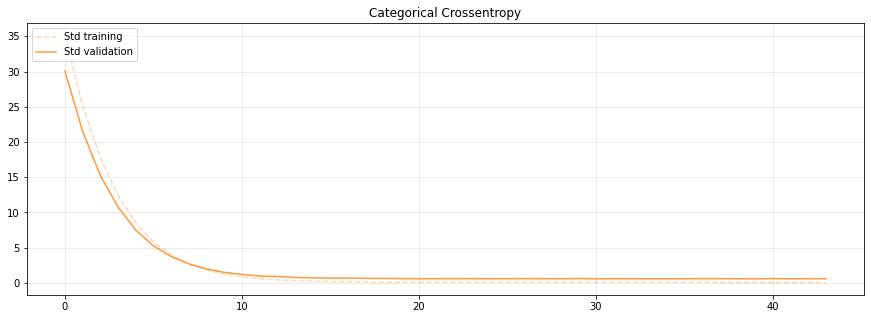

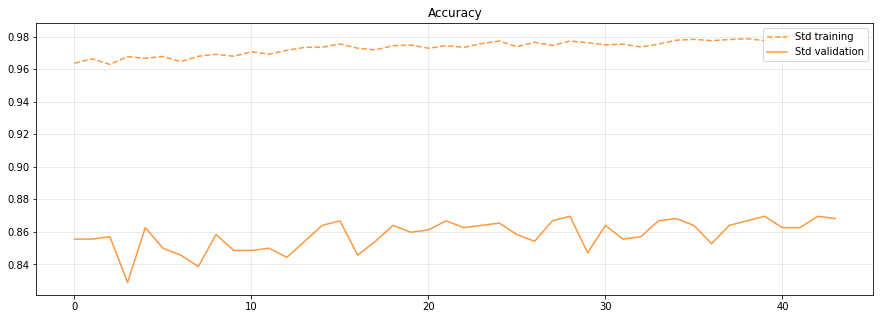

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8696
Precision: 0.8614
Recall: 0.8266
F1: [0.5538 0.8571 0.9238 0.8899 0.9108 0.8205 0.9135 0.8374]


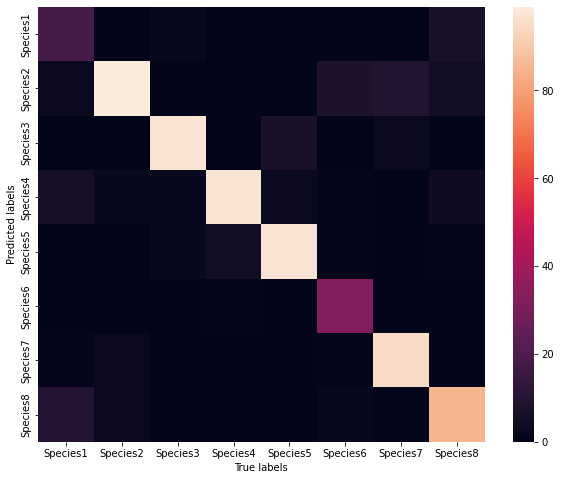

In [33]:
tuning_model_l2_v2 = tune_supernetL2_v2(input_shape)
tuning_model_l2_v2.summary()

history = tuning_model_l2_v2.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_v2.save('xception_tuned_l2_v2', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_v2', 'zip', 'xception_tuned_l2_v2')
FileLink(r'xception_tuned_l2_v2.zip')

plot_history(history)
score_model(tuning_model_l2_v2)

Model: "tuned_model_l2_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 3, 2048)   20861480    input_layer[0][0]                
__________________________________________________________________________________________________
gap (GlobalAveragePooling2D)    (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
dense4 (Dense)                  (None, 2048)         4196352     gap[0][0]                        
__________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 38s 597ms/step - loss: 0.1419 - accuracy: 0.9535 - val_loss: 0.7706 - val_accuracy: 0.8555
Epoch 2/400
61/61 [==============================] - 36s 593ms/step - loss: 0.1261 - accuracy: 0.9582 - val_loss: 0.8647 - val_accuracy: 0.8233
Epoch 3/400
61/61 [==============================] - 36s 588ms/step - loss: 0.1283 - accuracy: 0.9577 - val_loss: 0.6615 - val_accuracy: 0.8513
Epoch 4/400
61/61 [==============================] - 36s 600ms/step - loss: 0.1083 - accuracy: 0.9623 - val_loss: 0.6909 - val_accuracy: 0.8401
Epoch 5/400
61/61 [==============================] - 35s 585ms/step - loss: 0.1029 - accuracy: 0.9665 - val_loss: 0.6528 - val_accuracy: 0.8415
Epoch 6/400
61/61 [==============================] - 36s 589ms/step - loss: 0.0969 - accuracy: 0.9656 - val_loss: 0.6106 - val_accuracy: 0.8612
Epoch 7/400
61/61 [==============================] - 36s 591ms/step - loss: 0.0971 - accuracy: 0.9648 - val_loss: 0.6981 - val_accuracy: 0.8373
Epoc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


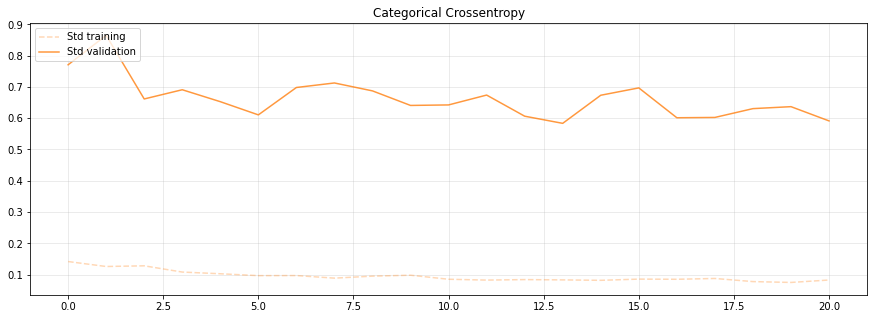

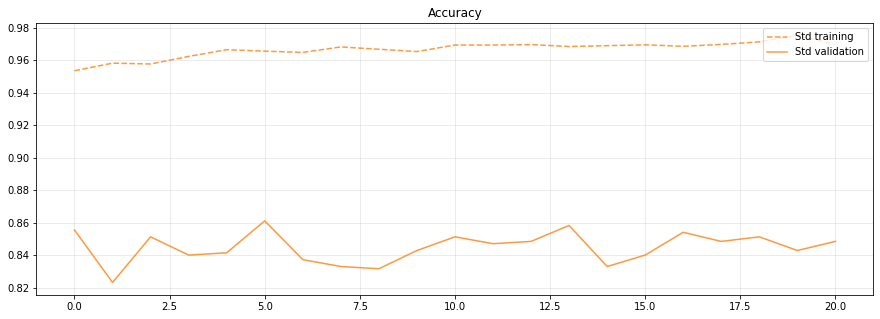

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.8612
Precision: 0.8484
Recall: 0.824
F1: [0.5373 0.8767 0.9023 0.8558 0.8868 0.8642 0.9259 0.8159]


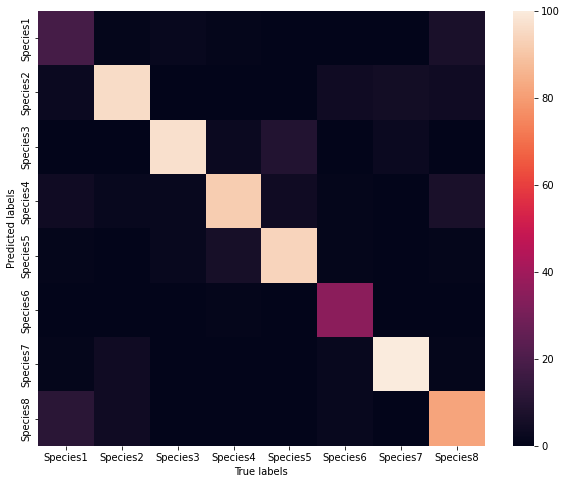

In [34]:
tuning_model_l2_v3 = tune_supernetL2_v3(input_shape)
tuning_model_l2_v3.summary()

history = tuning_model_l2_v3.fit(x=train_dataset,
                       # Only indicative since we set "repeat" in training and validation datasets
                       epochs=epochs,
                       steps_per_epoch=int(len(train_gen)),
                       validation_data=valid_dataset,
                       validation_steps=len(valid_gen),
                       class_weight=class_weights,
                       callbacks=[early_stop, tfk.callbacks.LearningRateScheduler(scheduler_tuning)]
                       ).history

tuning_model_l2_v3.save('xception_tuned_l2_v3', include_optimizer=False)

shutil.make_archive('xception_tuned_l2_v3', 'zip', 'xception_tuned_l2_v3')
FileLink(r'xception_tuned_l2_v3.zip')

plot_history(history)
score_model(tuning_model_l2_v3)